In [ ]:
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D, LSTM, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_true = pd.read_csv("/content/drive/MyDrive/Fake News Dataset/True.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/Fake News Dataset/Fake.csv")

df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_true['label'] = 0
df_fake['label'] = 1

In [ ]:
df_true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [ ]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [ ]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [ ]:
# from sklearn.preprocessing import LabelEncoder
# lb = LabelEncoder()
# df['label'] = lb.fit_transform(df['label'])
# df['label'].unique()

In [ ]:
df = pd.concat([df_true, df_fake])
random_permutation = np.random.permutation(len(df))
df = df.iloc[random_permutation]
print(df.columns)
df.head()

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


,title,text,subject,date,label
12607,"Hardline Indonesian Muslim groups burn U.S., I...",JAKARTA (Reuters) - Hardline Muslim groups in ...,worldnews,"December 11, 2017",0
18752,200 SOCIALIST RADICALS Storm Heritage Foundati...,A group called People s Action just held the...,left-news,"Apr 25, 2017",1
22738,Robert Parry: Sorting Out the Russia Mess,Consortium News Exclusive: The U.S. mainstream...,Middle-east,"October 31, 2017",1
20745,HERE’S A PERFECT EXAMPLE OF WHY People Don’t T...,The massive shroud of secrecy in Muslim commun...,left-news,"Apr 13, 2016",1
21398,Blunt instrument? What a list of banned articl...,SHANGHAI (Reuters) - An old review of an acade...,worldnews,"August 23, 2017",0


In [ ]:
df.head()

,title,text,subject,date,label
12607,"Hardline Indonesian Muslim groups burn U.S., I...",JAKARTA (Reuters) - Hardline Muslim groups in ...,worldnews,"December 11, 2017",0
18752,200 SOCIALIST RADICALS Storm Heritage Foundati...,A group called People s Action just held the...,left-news,"Apr 25, 2017",1
22738,Robert Parry: Sorting Out the Russia Mess,Consortium News Exclusive: The U.S. mainstream...,Middle-east,"October 31, 2017",1
20745,HERE’S A PERFECT EXAMPLE OF WHY People Don’t T...,The massive shroud of secrecy in Muslim commun...,left-news,"Apr 13, 2016",1
21398,Blunt instrument? What a list of banned articl...,SHANGHAI (Reuters) - An old review of an acade...,worldnews,"August 23, 2017",0


In [ ]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [ ]:
df['feature'] = df['title']+' '+df['text']+' '+df['subject']

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df['feature'] = df['feature'].str.lower()
df.head()

import string
def remove_punctuations(text):
    punctuations = set(string.punctuation)
    text = str(text)
    # return text.translate(str.maketrans('', '', punctuations))
    return " ".join([word for word in text.split() if word not in punctuations])

df['feature'] = df['feature'].apply(lambda x: remove_punctuations(x))

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

df['feature'] = df['feature'].apply(lambda x: remove_stopwords(x))

import re
def remove_spl_chars(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

df['feature'] = df['feature'].apply(lambda x: remove_spl_chars(x))

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')
def stem(text):
    stemmed_sentence = " ".join(stemmer.stem(word) for word in text.split())
    return stemmed_sentence

df['feature'] = df['feature'].apply(lambda x: stem(x))

# def remove_url(text):
#     return re.sub(r'https?://\S+|www\.\S+', '', text)

# df['feature'] = df['feature'].apply(lambda x: remove_url(x))

In [ ]:
len(df)

44898

In [ ]:
df.dropna(subset=['feature'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
texts = []
labels = []
for i in range(44894):
    texts.append(df['text'][i])
    labels.append(df['label'][i])

print(len(texts))
len(labels)

44894


44894

In [ ]:
max_words = 100000
max_seq_length = 2000
# the percentage of train test split to be applied
validation_split = 0.2
# the dimension of vectors to be used
embedding_dim = 200
# filter sizes of the different conv layers
filter_sizes = [3,4,5]
num_filters = 512
# dropout probability
drop = 0.5
batch_size = 30
epochs = 2

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
word_index = tokenizer.word_index
len(word_index)

138012

In [ ]:
data = pad_sequences(sequences, maxlen=max_seq_length)
labels = np.asarray(labels)
print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

Shape of data tensor:  (44894, 2000)
Shape of label tensor:  (44894,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(validation_split * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
max = 0
for i in range(44894):
    l = len(sequences[i])
    if l > max:
        max = l
max

8375

In [ ]:
y_train[0:5]

array([1, 0, 1, 0, 1])

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
!ls
!pwd

--2024-01-29 13:57:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-29 13:57:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-29 13:57:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embeddings_idx = {}
f = open("./glove.6B.100d.txt", encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_idx[word] = coefs
f.close()

In [ ]:
len(embeddings_idx['prison'])

100

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
def Bi_LSTM():
    inputs = Input(name='inputs',shape=[max_seq_length])
    layer = Embedding(max_words, 100,input_length=max_seq_length)(inputs)
    layer = Bidirectional(LSTM(32))(layer)
    layer = Dense(256,name='FC1')(layer)
    # layer = Dense(128,name='FC2')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
from keras.optimizers import RMSprop
import tensorflow as tf
model = Bi_LSTM()
with tf.device('/device:GPU:0'):
  model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 2000)]            0         
                                                                 
 embedding (Embedding)       (None, 2000, 100)         10000000  
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [ ]:
history = model.fit(x_train,y_train, batch_size=128, epochs=3, validation_split=0.2)

Epoch 1/3
225/225 [==============================] - 59s 232ms/step - loss: 0.1730 - accuracy: 0.9337 - val_loss: 0.1965 - val_accuracy: 0.9440
Epoch 2/3
225/225 [==============================] - 46s 205ms/step - loss: 0.0299 - accuracy: 0.9918 - val_loss: 0.0256 - val_accuracy: 0.9929
Epoch 3/3
225/225 [==============================] - 48s 211ms/step - loss: 0.0146 - accuracy: 0.9965 - val_loss: 0.0652 - val_accuracy: 0.9812


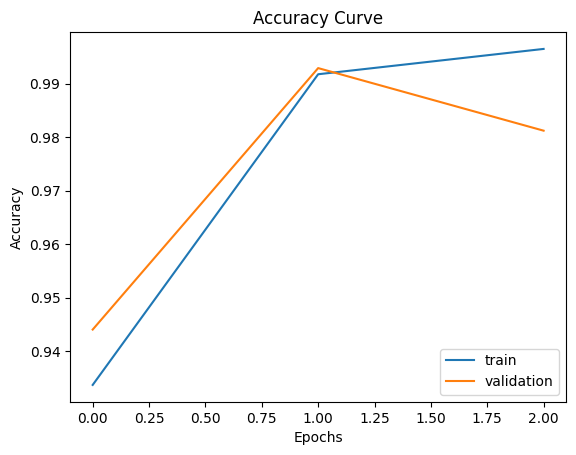

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

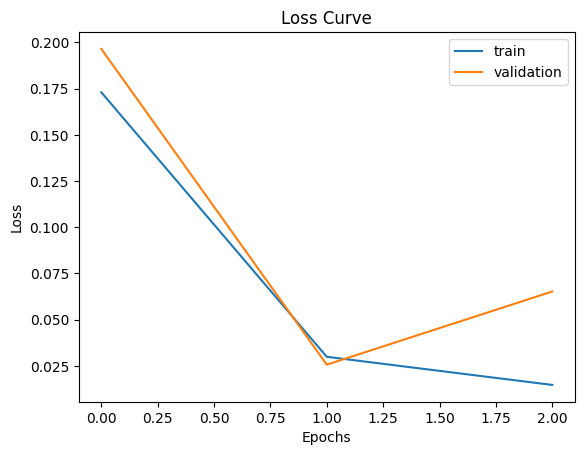

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
y_pred = model.predict(x_val)

281/281 [==============================] - 15s 52ms/step


In [ ]:
pred = []
for p in y_pred:
  if p[0] > 0.5:
    pred.append(1)
  else:
    pred.append(0)

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
a = accuracy_score(pred, y_val)

In [ ]:
a

0.9797282245488973

In [ ]:
cm = confusion_matrix(pred, y_val)
cm

array([[4147,   21],
       [ 161, 4649]])

In [ ]:
count_0 = 0
count_1 = 0
for p in y_val:
  if p == 0:
    count_0 += 1
  else:
    count_1 += 1

In [ ]:
count_0

4308

In [ ]:
count_1

4670

In [ ]:
cl = classification_report(pred, y_val)
print(cl)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4168
           1       1.00      0.97      0.98      4810

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978

